In [83]:
!pip install Augmentor

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [98]:
data_dir_train = pathlib.Path("/content/drive/My Drive/cancer/Train/")
data_dir_test = pathlib.Path("/content/drive/My Drive/cancer/Test/")

In [99]:
data_dir_test

PosixPath('/content/drive/My Drive/cancer/Test')

In [100]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [101]:
batch_size = 32
img_height = 180
img_width = 180

In [102]:
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [103]:
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


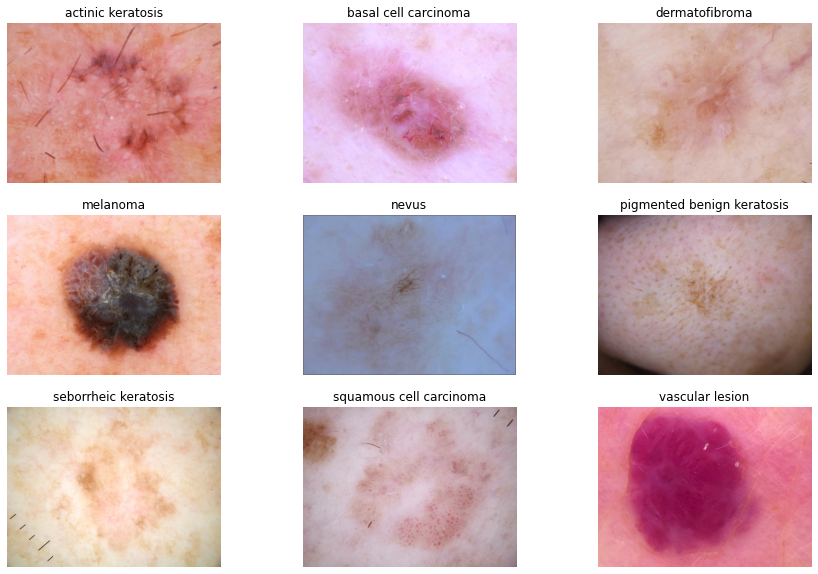

In [104]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [105]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [106]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [107]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

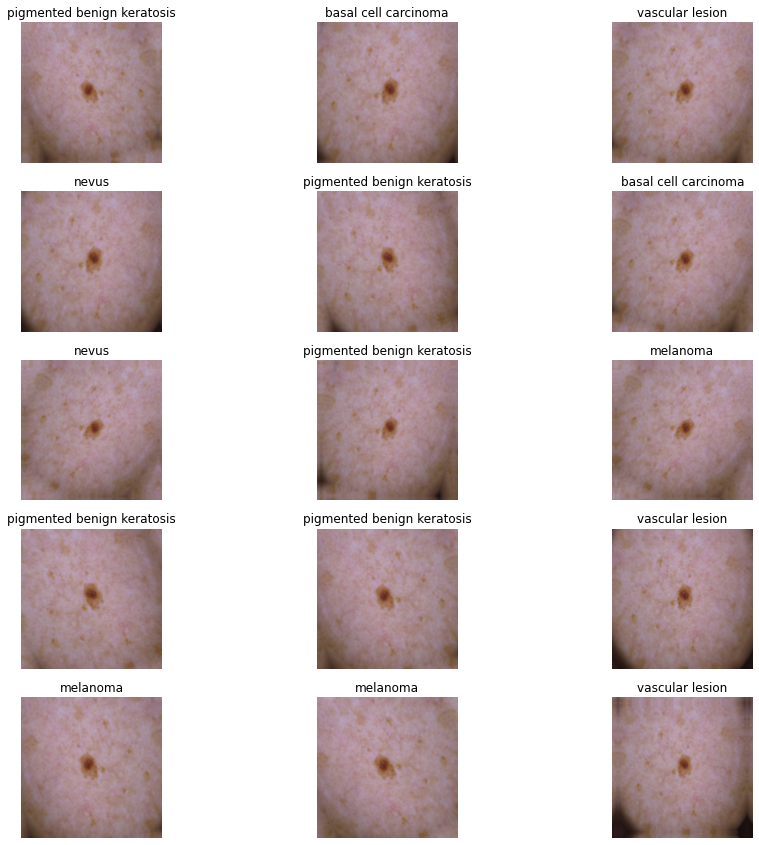

In [108]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [109]:
num_classes = 9

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [110]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_16 (Activation)  (None, 180, 180, 16)      0         
                                                      

In [112]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 122ms/step - loss: 1.9008 - accuracy: 0.3097 - val_loss: 1.6833 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 1.6513 - accuracy: 0.3839 - val_loss: 1.5752 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5378 - accuracy: 0.4498 - val_loss: 1.5027 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4590 - accuracy: 0.4888 - val_loss: 1.4592 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3644 - accuracy: 0.5106 - val_loss: 1.4248 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3260 - accuracy: 0.5246 - val_loss: 1.3314 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.2922 - accuracy: 0.5396 - val_loss: 1.3566 - val_accuracy: 0.5347
Epoch 8/20
5

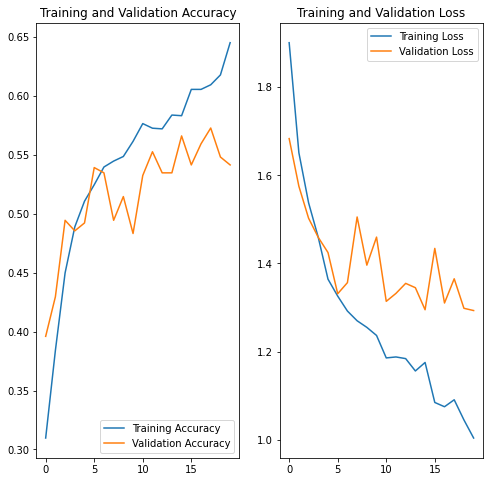

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [114]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [115]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


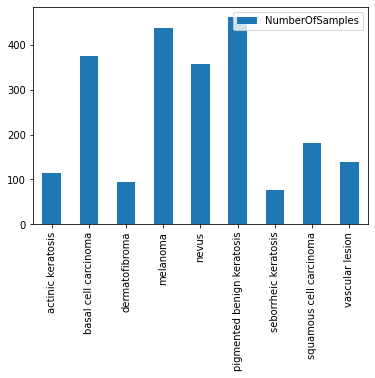

In [116]:
class_df.plot.bar()
plt.show()

In [117]:
import Augmentor

In [118]:
path_to_training_dataset = '/content/drive/My Drive/cancer/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/drive/My Drive/cancer/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFB9B4EA310>: 100%|██████████| 1000/1000 [00:45<00:00, 21.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA5ACDD10>: 100%|██████████| 1000/1000 [00:45<00:00, 22.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA5784190>: 100%|██████████| 1000/1000 [00:45<00:00, 21.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFB2135F810>: 100%|██████████| 1000/1000 [03:30<00:00,  4.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FFAA6661590>: 100%|██████████| 1000/1000 [03:12<00:00,  5.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA5A54190>: 100%|██████████| 1000/1000 [00:45<00:00, 22.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFAA5685F90>: 100%|██████████| 1000/1000 [01:42<00:00,  9.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA617CC50>: 100%|██████████| 1000/1000 [00:44<00:00, 22.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/cancer/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFB213A7510>: 100%|██████████| 1000/1000 [00:45<00:00, 22.02 Samples/s]


In [119]:
output_dir = pathlib.Path('/content/drive/My Drive/cancer/working/')

In [120]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

18000


In [121]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [122]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [123]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [124]:
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [125]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_20 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

In [127]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
450/450 [==============================] - 108s 86ms/step - loss: 2.2486 - accuracy: 0.1510 - val_loss: 2.1996 - val_accuracy: 0.1697
Epoch 2/30
450/450 [==============================] - 21s 48ms/step - loss: 1.5535 - accuracy: 0.4094 - val_loss: 1.3726 - val_accuracy: 0.4933
Epoch 3/30
450/450 [==============================] - 21s 48ms/step - loss: 1.1467 - accuracy: 0.5773 - val_loss: 0.9863 - val_accuracy: 0.6328
Epoch 4/30
450/450 [==============================] - 21s 47ms/step - loss: 0.8837 - accuracy: 0.6792 - val_loss: 0.9008 - val_accuracy: 0.6856
Epoch 5/30
450/450 [==============================] - 21s 47ms/step - loss: 0.7059 - accuracy: 0.7474 - val_loss: 0.7371 - val_accuracy: 0.7242
Epoch 6/30
450/450 [==============================] - 21s 47ms/step - loss: 0.5631 - accuracy: 0.8014 - val_loss: 0.5591 - val_accuracy: 0.8167
Epoch 7/30
450/450 [==============================] - 21s 47ms/step - loss: 0.4844 - accuracy: 0.8297 - val_loss: 0.4874 - val_accuracy

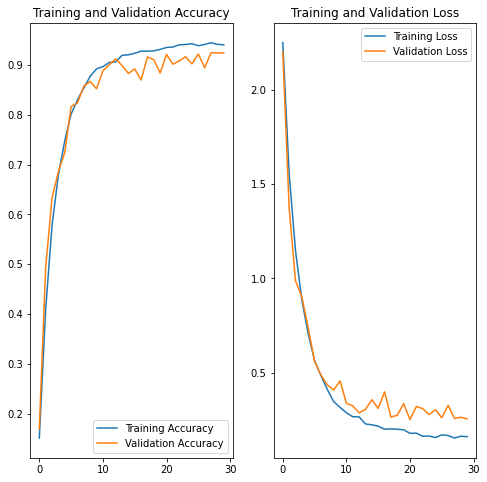

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [129]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [130]:
num_classes = 9

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [131]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [132]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_24 (Activation)  (None, 180, 180, 16)      0         
                                                      

In [133]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
450/450 [==============================] - 23s 50ms/step - loss: 1.7049 - accuracy: 0.3423 - val_loss: 1.3460 - val_accuracy: 0.4592
Epoch 2/50
450/450 [==============================] - 22s 49ms/step - loss: 1.2992 - accuracy: 0.5020 - val_loss: 1.1660 - val_accuracy: 0.5561
Epoch 3/50
450/450 [==============================] - 22s 49ms/step - loss: 1.1591 - accuracy: 0.5603 - val_loss: 1.0567 - val_accuracy: 0.6064
Epoch 4/50
450/450 [==============================] - 22s 49ms/step - loss: 1.0053 - accuracy: 0.6211 - val_loss: 0.8793 - val_accuracy: 0.6658
Epoch 5/50
450/450 [==============================] - 22s 49ms/step - loss: 0.9050 - accuracy: 0.6597 - val_loss: 0.8238 - val_accuracy: 0.7142
Epoch 6/50
450/450 [==============================] - 22s 49ms/step - loss: 0.7763 - accuracy: 0.7138 - val_loss: 0.6895 - val_accuracy: 0.7556
Epoch 7/50
450/450 [==============================] - 22s 49ms/step - loss: 0.7227 - accuracy: 0.7308 - val_loss: 0.6714 - val_accuracy:

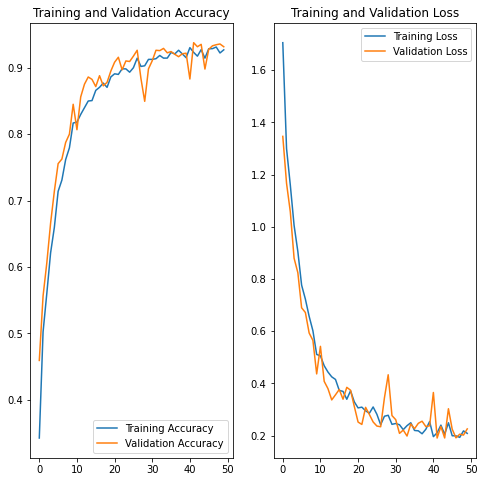

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [135]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0
 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1
 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0]
Labels:
 [1 0 1 3 5 0 5 6 3 4 1 4 5 2 3 5 4 0 7 0 0 0 4 5 7 7 8 3 5 1 5 0]


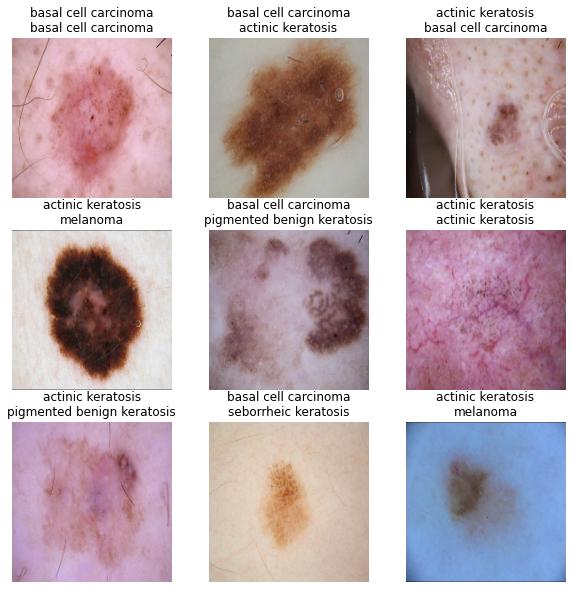

In [136]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")